In [83]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import os
import torch
import torch.nn as nn
import math
from matplotlib import colors
import pylab as plt
from skimage import io
import matplotlib.ticker as plticker
import torch.nn.functional as F
import torch.optim as optim

# Plot options
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 16})

In [89]:
# Access Manually Identified Bowties
print(os.getcwd())
os.chdir("..")
os.chdir("./Downloads/Topic 2/Topic 2/Manually Identified Bowties/") 

l0bowtie = [k for k in os.listdir() if '_0.npy' in k] # create a list with all 0 degree images from manually identified bowties
l45bowtie = [k for k in os.listdir() if '_45.npy' in k] # create a list with all 45 degree images from manually identified bowties

# Access Manually Identified Other
os.chdir("..")
os.chdir("./Manually Identified Other/") 

l0other = [k for k in os.listdir() if '_0.npy' in k] # create a list with all 0 degree images from manually identified other
l45other = [k for k in os.listdir() if '_45.npy' in k] # create a list with all 45 degree images from manually identified other

c:\Users\aaris\Downloads


In [90]:
os.chdir("..")
os.chdir("./Manually Identified Bowties/") 

var = 40 # if convolved image, change to 38 (otherwise, leave at 40)

l0b = torch.empty([int(len(l0bowtie)), 1, var, var])
count0b = 0

for i in range(0, len(l0bowtie)):
    newArray = np.load(l0bowtie[i])

    if newArray.shape == (var, var):
        l0b[i] = torch.from_numpy(newArray) 
        count0b += 1

    # else:
    #     print(f"Array Shape: {newArray.shape}")
    #     print(f"hey this isn't working!!!")

os.chdir("..")
os.chdir("./Manually Identified Other/") 

l0o = torch.empty([int(len(l0other)), 1, var, var])
count0o = 0

for i in range(0, len(l0other)):
    newArray = np.load(l0other[i])

    if newArray.shape == (var, var):
        l0o[i] = torch.from_numpy(newArray)
        count0o += 1

In [91]:
total = count0b + count0o
print(f"Number of Images: {total}")
x = torch.cat((l0b[0:count0b], l0o[0:count0o]), 0)
print(f"Training Set Shape: {x.shape}")

y1 = torch.ones(count0b)
y2 = torch.zeros(count0o)
y = torch.cat((y1, y2), 0)
print(f"Testing Set Shape: {y.shape}")

Number of Images: 990
Training Set Shape: torch.Size([990, 1, 40, 40])
Testing Set Shape: torch.Size([990])


In [92]:
torch.manual_seed(0)
idx = torch.randperm(total)
x = x[idx]
y = y[idx]

trainingSet = round(total*0.8)
xtrain = x[:trainingSet]
xtest = x[trainingSet:]
ytrain = y[:trainingSet]
ytest = y[trainingSet:]

print(f"xtrain shape: {xtrain.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"xtest shape: {xtest.shape}")
print(f"ytest shape: {ytest.shape}")

xtrain shape: torch.Size([792, 1, 40, 40])
ytrain shape: torch.Size([792])
xtest shape: torch.Size([198, 1, 40, 40])
ytest shape: torch.Size([198])


In [93]:
class convNeuralNetwork(nn.Module):
    def __init__(self):
        super(convNeuralNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, (3, 3), padding = 'same'), # 10x40x40
            nn.ReLU(),
            nn.MaxPool2d(2), #10x20x20
            nn.Conv2d(10, 20, (3, 3), padding = 'same'), #20x20x20
            nn.ReLU(),
            nn.MaxPool2d(2), #20x10x10
            nn.Conv2d(20, 40, (3, 3), padding = 'same'), # 40x10x10
            nn.ReLU(),
            nn.MaxPool2d(2) # 40x5x5
        )

        self.flatten = nn.Flatten()

        self.fullyConnected = nn.Sequential(
            nn.Linear(1000, 10), 
            nn.ReLU(),
            nn.Linear(10, 2) # Output is 0 or 1    
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fullyConnected(x)
        return x
    
net = convNeuralNetwork()

In [94]:
# Define relevant variables for the task
num_epochs = 80
batch_size = 32
learning_rate = 0.001

model = convNeuralNetwork()

# Set loss function/criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)  


In [95]:
train_loss = []
test_accuracy = []

net.train()
total_step = len(xtrain)

for epoch in range(num_epochs):
    running_loss = 0

    for i in range(0, len(xtrain), batch_size):
        # obtain inputs
        x, y = xtrain[i : i + batch_size], ytrain[i : i + batch_size]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(x)
        loss = criterion(output, y.type(torch.long)) # convert float tensor to integer tensor
        loss.backward()
        optimizer.step()

        # append loss statistic
        running_loss += loss.item()

    train_loss.append(running_loss / total_step)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss:{train_loss[-1]:.4f}")

    # Test loss
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        correct = 0
        total = 0
        for i in range(0, len(xtest), batch_size):
            # obtain inputs
            x, y = xtest[i : i + batch_size], ytest[i : i + batch_size]

            # run images through network and obtain output
            output = net(x)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum()
            total += y.size(0)
            
        accuracy = (100 * correct / total).item()
        test_accuracy.append(accuracy)
    if epoch % 10 == 0: # Print every 10 epochs
        print(f"Epoch [{epoch + 1}/{num_epochs}], Test Accuracy:{test_accuracy[-1]:.4f}")

Epoch [1/80], Loss:0.0138
Epoch [1/80], Test Accuracy:92.4242
Epoch [2/80], Loss:0.0039
Epoch [3/80], Loss:0.0024
Epoch [4/80], Loss:0.0016
Epoch [5/80], Loss:0.0013
Epoch [6/80], Loss:0.0005
Epoch [7/80], Loss:0.0006
Epoch [8/80], Loss:0.0005
Epoch [9/80], Loss:0.0005
Epoch [10/80], Loss:0.0004
Epoch [11/80], Loss:0.0005
Epoch [11/80], Test Accuracy:98.9899
Epoch [12/80], Loss:0.0003
Epoch [13/80], Loss:0.0001
Epoch [14/80], Loss:0.0000
Epoch [15/80], Loss:0.0000
Epoch [16/80], Loss:0.0000
Epoch [17/80], Loss:0.0000
Epoch [18/80], Loss:0.0000
Epoch [19/80], Loss:0.0000
Epoch [20/80], Loss:0.0000
Epoch [21/80], Loss:0.0000
Epoch [21/80], Test Accuracy:99.4949
Epoch [22/80], Loss:0.0000
Epoch [23/80], Loss:0.0000
Epoch [24/80], Loss:0.0000
Epoch [25/80], Loss:0.0000
Epoch [26/80], Loss:0.0000
Epoch [27/80], Loss:0.0000
Epoch [28/80], Loss:0.0000
Epoch [29/80], Loss:0.0000
Epoch [30/80], Loss:0.0000
Epoch [31/80], Loss:0.0000
Epoch [31/80], Test Accuracy:99.4949
Epoch [32/80], Loss:0.000

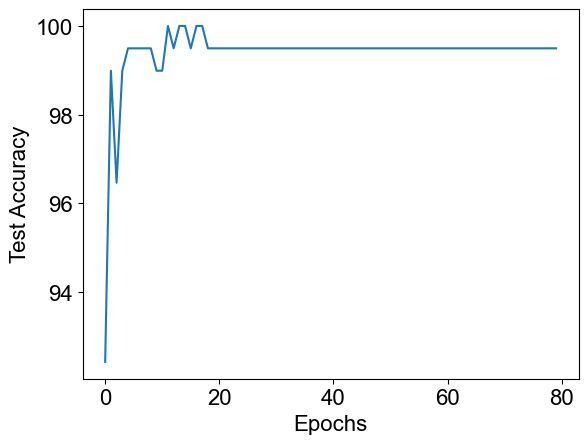

In [96]:
plt.plot(test_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

Accuracy: 99.49%


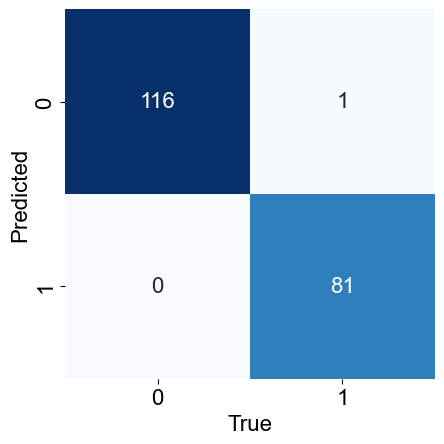

In [97]:
_, predicted_labels = torch.max(net(xtest), 1)
accuracy = (ytest == predicted_labels).sum()/len(ytest) * 100
print(f"Accuracy: {accuracy:.2f}%")
confmat = confusion_matrix(ytest, predicted_labels)

sn.heatmap(confmat, fmt="g", cmap="Blues", square=True, cbar=False, annot=True)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()